In [85]:
# 1D with central differencing scheme

import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# TODO: Add reference later
"""
A property φ is transported by means of convection and diffusion through
the one-dimensional domain; the boundary conditions are φ0 = 1 at x = 0 and 
φL = 0 at x = L. Using five equally spaced cells and the central differencing 
scheme for convection and diffusion, calculate the distribution of φ as a 
function of x for (i) Case 1: u = 0.1 m/s, (ii) Case 2: u = 2.5 m/s, 
and compare the results with the analytical solution (iii) Case 3: recalculate 
the solution for u = 2.5 m/s with 20 grid nodes and compare the results with 
the analytical solution. The following data apply: length L = 1.0 m, ρ = 1.0 kg/m3
, Γ = 0.1 kg/m.s.
"""

import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Parameters
L = 1.0              # Length in m
rho = 1.0            # Density in kg/m3
k = 0.1              # Diffusivity in kg/m.s
u = 0.1              # Velocity in m/s
n_nodes = 5
dx = L / n_nodes

# Boundary conditions
phi_x0 = 1
phi_xL = 0

# Calculate diffusion and mass flux terms
D = k / dx            # Diffusion conductance
F = u * rho           # Mass flux per unit area

def numerical_sol(D, F, n_nodes):
    # Initialise the right-hand side vector
    b = np.zeros(n_nodes)

    # Initialise the diagonals of the matrix
    a_W = D + 0.5 * F
    a_E = D - 0.5 * F
    a_P = a_W + a_E 

    # Set up the main diagonal, super-diagonal, and sub-diagonal
    main_diag = np.full(n_nodes, a_P)
    sup_diag = np.full(n_nodes - 1, -a_E)
    sub_diag = np.full(n_nodes - 1, -a_W)

    # Modify the first and last nodes for boundary conditions
    main_diag[0] = a_E + (2 * D + F)
    b[0] = (2 * D + F) * phi_x0
    main_diag[-1] = a_W + (2 * D - F)
    b[-1] = (2 * D - F) * phi_xL

    # Create a sparse tridiagonal matrix
    diagonals = [main_diag, sup_diag, sub_diag]
    A = diags(diagonals, [0, 1, -1], format='csr')

    # Solve the linear system
    return spsolve(A, b)

def get_xs(L, n_nodes):
    dx = L/n_nodes
    return np.linspace(0, L - dx, n_nodes) + dx / 2
    


In [86]:
def analytical_sol(x):
    return (phi_xL - phi_x0) * (np.exp(rho*u*x/k) - 1)/(np.exp(rho*u*L/k) - 1) + phi_x0

phi_dist_act = analytical_sol(x_grid)
phi_dist_num = numerical_sol(D, F, n_nodes)

In [87]:
import matplotlib.pyplot as plt

def plot(title='', show_num_line=False):
    # Calculate control volume nodes
    x_grid = get_xs(L, n_nodes)

    plt.scatter(x_grid, phi_dist_num, marker='D', color='k')
    if show_num_line:
        plt.plot(x_grid, phi_dist_num, color='k')
    plt.plot(x_grid, phi_dist_act, color='k')
    plt.legend(['Numerical solution (CD)', 'Exact solution'])
    plt.title(title)
    plt.xlabel('Distance (m)')
    plt.ylabel('φ')
    plt.show()

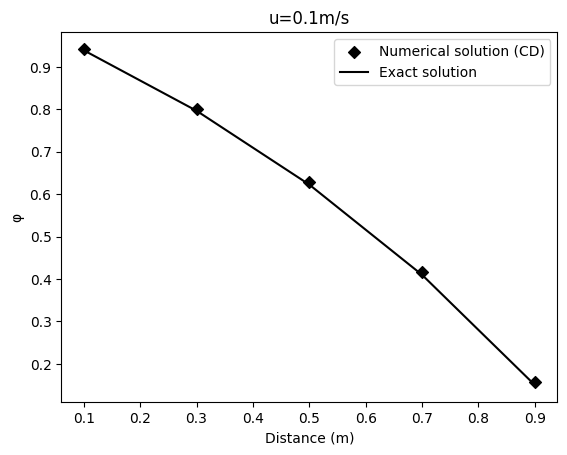

In [88]:
plot(title='u=0.1m/s')

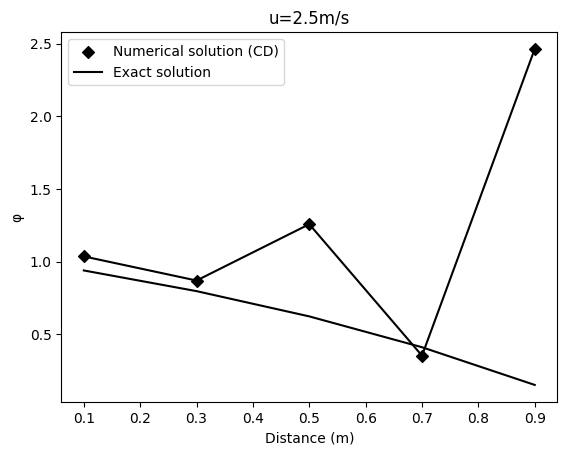

In [89]:
# Case 2

F = 2.5
D = 0.1/0.2

phi_dist_num = numerical_sol(D, F, n_nodes)

plot(title='u=2.5m/s', show_num_line=True)

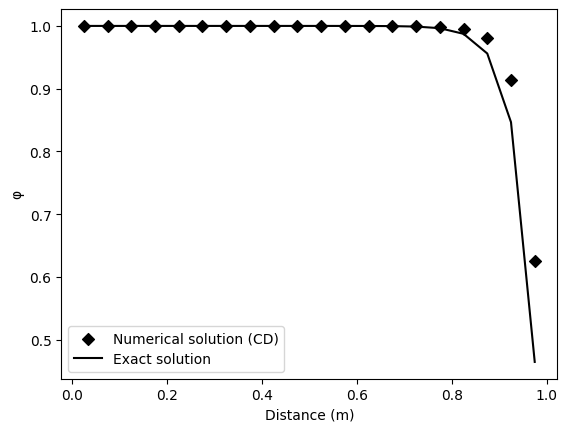

In [90]:
# Case 3
u = 2.5
n_nodes = 20
dx = L/n_nodes
F = rho*u
D = k/dx

phi_dist_act = analytical_sol(get_xs(L, n_nodes))
phi_dist_num = numerical_sol(D, F, n_nodes)
plot()